# VanillaNet Components

In [1]:
from torch import nn
import torch
import torch.nn.functional as F

/Users/drwho/anaconda3/lib/python3.9/site-packages/torch/onnx/_internal/_beartype.py:30: UserWarning: module 'beartype.roar' has no attribute 'BeartypeDecorHintPep585DeprecationWarning'
  warnings.warn(f"{e}")


In [2]:
from timm.models.layers import DropPath, trunc_normal_
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

/Users/drwho/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/drwho/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE)
  Referenced from: '/Users/drwho/anaconda3/lib/python3.9/site-packages/torchvision/image.so'
  Expected in: '/Users/drwho/anaconda3/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'
  warn(f"Failed to load image Python extension: {e}")


In [3]:
from typing import Optional, List

In [4]:
from ipywidgets import interact

## Observation
* When finetune, you should start the act_learn with 1
* decomposing rank might contribute to other design related to size.

## Activation
> Series Informed Activation Function

It means the activation can be informed by the surrounding areas, not only the current pixel. In paper, it use $n$ to denote a range of shift $[-n, n]$. As you might have guessed, they use a convolutional,kernel to implement this function, as it's already good & fast calculation on shifting. Hence when you have activation number $n$, you will have a $2n+1$ kernel size convolution.

### Fuse
The fuse happens when training ends and inference starts

They will transform a `conv w/o bias + bn` to `cnov w/ bias`

Same fuse happens to other structure in this paper.

Given the fused weights, you can't transform back to the original weights.

### Batch Normalization

Under usual batch normalization the following is computed and updated, notice it involves 4 players (learnable parameters): $\gamma, \beta, \mu, \sigma^2$

#### Calculation & Update

Mean of the batch, easy to compute

$
\mu_B = \frac{1}{m} \sum_{i=1}^{m} x_i
$

The following is basically standard deviation of the batch

$
\sigma_B^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu_B)^2
$

Normalize the batch, shift the distribution to zero mean and unit variance

$
\hat{x_i} = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}
$

Running mean and variance update (using mmentum to decay the running mean and variance)

$
\mu = \alpha \mu + (1 - \alpha) \mu_B$

$
\sigma^2 = \alpha \sigma^2 + (1 - \alpha) \sigma_B^2
$

Scale and shift the normalized batch

$
y_i = \gamma \hat{x_i} + \beta
$

In [5]:
def fusing_conv_and_bn(kernel, bias, gamma, beta, running_mean, running_var, eps: float = 1e-6):
    """
    Combine the convolutional kernel and the batch normalization parameters.
    besides eps, all parameters are learnable parameters.

    kernel, bias are from the convolutional layer.
    gamma, beta, running_mean, running_var are from the batch normalization layer.

    The output is a new kernel and a new bias, which can be used to replace the original convolutional layer.
    """
    with torch.no_grad():
        std = (running_var + eps).sqrt()
        t = (gamma / std).reshape(-1, 1, 1, 1)
        return kernel * t, beta + (bias - running_mean) * gamma / std


class FuseBNMixin:
    """
    A mixin class that can be used to fuse the batch normalization layer into the convolutional layer.
    """
    def _fuse_bn_tensor(self, conv: nn.Conv2d, bn: nn.Module):
        """
        Fuse the convolutional layer weights and the batchnorm layer into one layer.
        """
        new_kernel, new_bias = fusing_conv_and_bn(
            # variables from the convolutional layer
            kernel=conv.weight, bias=conv.bias,
            # variables from the batchnorm layer
            gamma=bn.weight, beta=bn.bias, running_mean=bn.running_mean, running_var=bn.running_var, eps=bn.eps)
        return new_kernel, new_bias
        

In [6]:
class SIActivation(nn.Module):
    """
    Series informed activation.
    """
    def __init__(self, dim: int, act_num: int = 3, inference: bool = False, activation_module: nn.Module = nn.ReLU()):
        super().__init__()

        self.dim = dim
        self.act_num = act_num
        self.inference = inference

        # The weight is in size of (channel_in, 1, kernel_size, kernel_size)
        self.weight = nn.Parameter(torch.randn(dim, 1, act_num*2+1, act_num*2+1))
        self.activation_module = activation_module
        
        if inference:
            self.bias = nn.Parameter(torch.zeros(dim))
        else:
            self.bn = nn.BatchNorm2d(dim, eps=1e-6)

        trunc_normal_(self.weight, std=.02)

    def _fuse_bn_tensor(self, weight: nn.Module, bn: nn.Module):
        """
        Fuse the convolutional layer weights and the batchnorm layer into one layer.
        """
        new_kernel, new_bias = fusing_conv_and_bn(
            # variables from the convolutional layer
            kernel=weight,
            bias=0, # we don't have bias before combine
            # variables from the batchnorm layer
            gamma=bn.weight,
            beta=bn.bias,
            running_mean=bn.running_mean,
            running_var=bn.running_var, eps=bn.eps)
        return new_kernel, new_bias
        
    def switch_to_inference(self):
        if self.inference:
            print("already in inference mode")
            return
        kernel, bias = self._fuse_bn_tensor(self.weight, self.bn)

        self.weight.data = kernel
        self.bias = nn.Parameter(bias)
        self.bn.to('cpu')
        self.__delattr__('bn')
        self.inference = True

    def forward(self, x: torch.Tensor):
        x = self.activation_module(x)
        if self.inference:
            return F.conv2d(x, self.weight, bias=self.bias, padding=self.act_num,
                groups=self.dim, #number of input channels
            )
        else:
            return self.bn(
                F.conv2d(x, self.weight, padding=self.act_num,
                    groups=self.dim, #number of input channels
                ))
        

In [7]:
si_leaky = SIActivation(64, 3, False, nn.LeakyReLU())
si_leaky

SIActivation(
  (activation_module): LeakyReLU(negative_slope=0.01)
  (bn): BatchNorm2d(64, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True)
)

In [8]:
x = torch.randn(1, 64, 32, 32)

Accumulate some running mean and var

In [9]:
with torch.no_grad():
    print(f"is inference: {si_leaky.inference}")
    y_1 = si_leaky(x.clone())

# you have to turn off the running stats of the batchnorm layer
# to compare the values
si_leaky.bn.eval()

is inference: False


BatchNorm2d(64, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True)

Let's compare the result before and after fuse

In [10]:
with torch.no_grad():
    print(f"is inference: {si_leaky.inference}")
    y_1 = si_leaky(x.clone())

si_leaky.switch_to_inference()

with torch.no_grad():
    print(f"is inference: {si_leaky.inference}")
    y_2 = si_leaky(x.clone())

is inference: False
is inference: True


As we can see the max difference between the two matrix is a number very close to zero.

In [11]:
(y_1 - y_2).abs().max()

tensor(1.1921e-07)

## Conv Block
> Where 2 convs can become 1


In [12]:
class VanillaConvBlock(nn.Module, FuseBNMixin):
    def __init__(
            self,
            dim: int,
            dim_out: int,
            act_num: int = 3,
            stride: int = 12,
            inference: bool = False,
            ada_pool: int  = None
                 ):
        super().__init__()
        self.act_learn = 1
        self.inference = inference

        if self.inference:
            self.conv = nn.Conv2d(dim, dim_out,kernel_size=1)

        else:
            self.conv1 = nn.Sequential(
                nn.Conv2d(dim, dim, kernel_size=1),
                nn.BatchNorm2d(dim, eps=1e-6)
            )
            self.conv2 = nn.Sequential(
                nn.Conv2d(dim, dim_out, kernel_size=1),
                nn.BatchNorm2d(dim_out, eps=1e-6)
            )

        if not ada_pool:
            self.pool = nn.Identity() if stride == 1 else nn.MaxPool2d(stride)
        else:
            self.pool = nn.Identity() if stride == 1 else nn.AdaptiveAvgPool2d((ada_pool, ada_pool))
        
        self.act = SIActivation(dim_out, act_num, inference=self.inference)

    def forward(self, x):
        if self.inference:
            x = self.conv(x)
        else:
            x = self.conv1(x)
            # by changing the act_learn,
            # we can decide how much of the activation we want in our block
            x = F.leaky_relu(x, self.act_learn)
            x = self.conv2(x)
        x = self.pool(x)
        x = self.act(x)
        return x
    
    def switch_to_inference(self):
        kernel, bias = self._fuse_bn_tensor(self.conv1[0], self.conv1[1])
        self.conv1[0].weight.data = kernel
        self.conv1[0].bias.data = bias

        kernel, bias = self._fuse_bn_tensor(self.conv2[0], self.conv2[1])
        self.conv = self.conv2[0]
        self.conv.weight.data = torch.matmul(
            kernel.transpose(1,3),
            self.conv1[0].weight.data.squeeze(3).squeeze(2)).transpose(1,3)
        self.conv.bias.data = bias + (self.conv1[0].bias.data.view(1,-1,1,1)*kernel).sum(3).sum(2).sum(1)
        self.__delattr__('conv1')
        self.__delattr__('conv2')
        self.act.switch_to_inference()
        self.inference = True

Let's setup some variables and params

In [13]:
INPUT_DIM = 64
x = torch.randn(1, INPUT_DIM, 32, 32)
vanilla_conv_block = VanillaConvBlock(INPUT_DIM, 128, 3, 1, False)

This step is to make sure we have valid parameters for the batchnorm layers

In [14]:
with torch.no_grad():
    print(f"is inference: {vanilla_conv_block.inference}")
    y_1 = vanilla_conv_block(x.clone())

is inference: False


In [15]:
def print_shape_and_num(x):
    """
    A helper function to print the shape and the number of parameters of a model.
    """
    report = ""
    for name, param in x.named_parameters():
        report += f"{name}:\t{param.shape} => {param.numel()}\n"
    report += "-" * 20
    report += f"\nTotal:\t{sum([param.numel() for param in x.parameters()])}"
    print(report)
    print("=" * 20, end="\n\n")

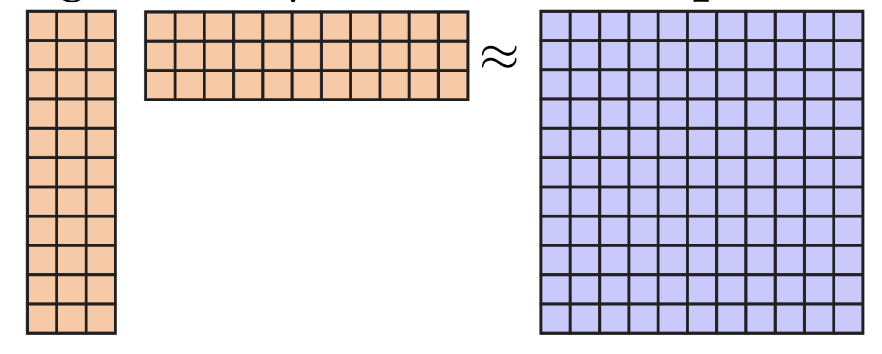

In [16]:
vanilla_conv_block.eval()
with torch.no_grad():
    print(f"is inference: {vanilla_conv_block.inference}")
    y_1 = vanilla_conv_block(x.clone())

    print_shape_and_num(vanilla_conv_block)

vanilla_conv_block.switch_to_inference()

with torch.no_grad():
    print(f"is inference: {vanilla_conv_block.inference}")
    y_2 = vanilla_conv_block(x.clone())

    print_shape_and_num(vanilla_conv_block)

is inference: False
conv1.0.weight:	torch.Size([64, 64, 1, 1]) => 4096
conv1.0.bias:	torch.Size([64]) => 64
conv1.1.weight:	torch.Size([64]) => 64
conv1.1.bias:	torch.Size([64]) => 64
conv2.0.weight:	torch.Size([128, 64, 1, 1]) => 8192
conv2.0.bias:	torch.Size([128]) => 128
conv2.1.weight:	torch.Size([128]) => 128
conv2.1.bias:	torch.Size([128]) => 128
act.weight:	torch.Size([128, 1, 7, 7]) => 6272
act.bn.weight:	torch.Size([128]) => 128
act.bn.bias:	torch.Size([128]) => 128
--------------------
Total:	19392

is inference: True
act.weight:	torch.Size([128, 1, 7, 7]) => 6272
act.bias:	torch.Size([128]) => 128
conv.weight:	torch.Size([128, 64, 1, 1]) => 8192
conv.bias:	torch.Size([128]) => 128
--------------------
Total:	14720



Before and after fuse comparison

In [17]:
(y_1 - y_2).abs().max()

tensor(7.6368e-08)

### Gradually fade out activation

In [18]:
from matplotlib import pyplot as plt
from plotly import graph_objects as go
from plotly import express as px

In [19]:
# create some random gaussian data
x = torch.randn(1, 3000)

visualize the histogram of the data

In [20]:
# visualize the histogram of the data
fig = px.histogram(x.view(-1).numpy(), nbins=100)
fig.show()

### How leaky is the leaky relu?
The more leaky it is, the closer this activation is close to linear

In [21]:
from ipywidgets import Output

In [22]:
out = Output()
display(out)
@interact
def how_leaky(scale=(0, 1., 0.01)):
    out.clear_output()
    act_learn = scale
    with torch.no_grad():
        y_ = nn.LeakyReLU(act_learn)(x)
        y_relu = nn.ReLU()(x)
    with out:
        fig = go.Figure()
        fig.add_trace(go.Histogram(x=x.view(-1).numpy(), nbinsx=50, name='x'))
        fig.add_trace(go.Histogram(x=y_.view(-1).numpy(), nbinsx=50, name='y_leaky'))
        fig.show()

Output()

interactive(children=(FloatSlider(value=0.5, description='scale', max=1.0, step=0.01), Output()), _dom_classes…

Explained on the graph below on [desmos](https://www.desmos.com/calculator/rplda0petg)
<iframe src="https://www.desmos.com/calculator/rplda0petg?embed" width="500" height="500" style="border: 1px solid #ccc" frameborder=0></iframe>

## VanillaNet

In [23]:
class VanillaNet(nn.Module, FuseBNMixin):
    def __init__(
            self,
            in_chans: int = 3,
            num_classes: Optional[int] = None,
            dims: List[int] = [96, 192, 384, 768],
            drop_rate: float = 0.,
            act_num: int = 3,
            strides: int = [2, 2, 2,],
            inference: bool = False,
            ada_pool: Optional[int] = None,
            act_learn: float = 1.,
            **kwargs
                 ):
        """
        num_classes: if set to None, we only load the backbone, without the top layer.
        """
        super().__init__()
        self.inference = inference
        self.num_classes = num_classes

        stride = 4 if not ada_pool else 3
        padding = 0 if not ada_pool else 1

        # num of dims should be 1 more than the num of strides
        if len(dims) != len(strides) + 1:
            raise ValueError("The length of dims should be 1 more than the length of strides.")

        if self.inference:
            self.stem = nn.Sequential(
                nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=stride, padding=padding),
                SIActivation(dims[0], act_num, inference=self.inference),
            )
        else:
            self.stem1 = nn.Sequential(
                nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=stride, padding=padding),
                nn.BatchNorm2d(dims[0], eps=1e-6),
            )
            self.stem2 = nn.Sequential(
                nn.Conv2d(dims[0], dims[0], kernel_size=1, stride=1, ),
                nn.BatchNorm2d(dims[0], eps=1e-6),
                SIActivation(dims[0], act_num, inference=self.inference),
            )

        self.act_learn: float = act_learn #1. # this equals to the leaky relu doesn't function at all

        self.stages = nn.ModuleList()
        
        # build model block by block
        for i in range(len(strides)):
            if not ada_pool:
                stage = VanillaConvBlock(dims[i], dims[i+1], act_num=act_num, stride=strides[i], inference=self.inference)
            else:
                stage = VanillaConvBlock(dims[i], dims[i+1], act_num=act_num, stride=strides[i], inference=self.inference, ada_pool=ada_pool)
            self.stages.append(stage)
        self.depth: int = len(self.stages)
        
        # top layer, if any
        if num_classes is not None:
            if self.inference:
                self.cls = nn.Sequential(
                    nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Dropout(drop_rate),
                    nn.Conv2d(dims[-1], num_classes, kernel_size=1),
                )
            else:
                self.cls1 = nn.Sequential(
                    nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Dropout(drop_rate),
                    nn.Conv2d(dims[-1], num_classes, kernel_size=1),
                    nn.BatchNorm2d(num_classes, eps=1e-6),
                )

                self.cls2 = nn.Sequential(nn.Conv2d(num_classes, num_classes, kernel_size=1))
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            trunc_normal_(m.weight, std=.02)
            nn.init.constant_(m.bias, 0)

    def change_act(self, m):
        """
        change the negative slope of the leaky relu
        """
        for i in range(self.depth):
            self.stages[i].act.act_learn = m
        self.act_learn = m

    def forward(self, x):
        # stem, 1st gate of the network
        if self.inference:
            x = self.stem(x)
        else:
            x = self.stem1(x)
            x = F.leaky_relu(x, self.act_learn)
            x = self.stem2(x)
        
        # stages
        for i in range(self.depth):
            x = self.stages[i](x)

        # top layer, if any
        if self.num_classes is None:
            # backbone only mode
            return x
        
        if self.inference:
            x = self.cls(x)
        else:
            x = self.cls1(x)
            x = F.leaky_relu(x, self.act_learn)
            x = self.cls2(x)
        return x.view(x.size(0), -1)
        
    def switch_to_inference(self):
        # Combine the stem1 and stem2 into one layer
        # since the stem1 has very different kernel size,
        # we need to specify a version of combining logic instead of using the VanillaConvBlock's
        stem2_conv, stem2_bn, stem2_act = self.stem2[0], self.stem2[1], self.stem2[2]
        stem2_act.switch_to_inference()
        stem1_conv, stem1_bn = self.stem1[0], self.stem1[1]
        stem1_conv.weight.data, stem1_conv.bias.data = self._fuse_bn_tensor(stem1_conv, stem1_bn)

        kernel, bias = self._fuse_bn_tensor(stem2_conv, stem2_bn)
        stem1_conv.weight.data = torch.einsum(
            'oi,icjk->ocjk',
            kernel.squeeze(3).squeeze(2),
            stem1_conv.weight.data)
        stem1_conv.bias.data = bias + (stem1_conv.bias.data.view(1,-1,1,1)*kernel).sum(3).sum(2).sum(1)

        self.stem = nn.Sequential(
            stem1_conv, stem2_act,)

        self.__delattr__('stem1')
        self.__delattr__('stem2')

        # Combine each stages

        for i in range(self.depth):
            self.stages[i].switch_to_inference()

        # Combine the top layer, if any

        if self.num_classes is None:
            # no top layer
            self.inference = True
            return
        
        # Combine the cls1 and cls2 into one layer
        cls2_conv = self.cls2[0]
        cls1_conv, cls1_bn = self.cls1[2], self.cls1[3]
        cls1_conv.weight.data, cls1_conv.bias.data = self._fuse_bn_tensor(cls1_conv, cls1_bn)

        cls1_conv.weight.data = torch.matmul(
            cls2_conv.weight.data.transpose(1,3),
            cls1_conv.weight.data.squeeze(3).squeeze(2)).transpose(1,3)
        cls1_conv.bias.data = cls2_conv.bias.data + (
            cls1_conv.bias.data.view(1,-1,1,1) * cls2_conv.weight.data).sum(3).sum(2).sum(1)
        self.cls = torch.nn.Sequential(
            *self.cls1[0:3],)
        self.__delattr__('cls1')
        self.__delattr__('cls2')
        self.inference = True


In [24]:
x = torch.randn(2, 3, 32, 32)
vanilla_net = VanillaNet(num_classes=100)

In [25]:
with torch.no_grad():
    print(f"is inference: {vanilla_net.inference}")
    y_1 = vanilla_net(x.clone())
    print_shape_and_num(vanilla_net)

is inference: False
stem1.0.weight:	torch.Size([96, 3, 4, 4]) => 4608
stem1.0.bias:	torch.Size([96]) => 96
stem1.1.weight:	torch.Size([96]) => 96
stem1.1.bias:	torch.Size([96]) => 96
stem2.0.weight:	torch.Size([96, 96, 1, 1]) => 9216
stem2.0.bias:	torch.Size([96]) => 96
stem2.1.weight:	torch.Size([96]) => 96
stem2.1.bias:	torch.Size([96]) => 96
stem2.2.weight:	torch.Size([96, 1, 7, 7]) => 4704
stem2.2.bn.weight:	torch.Size([96]) => 96
stem2.2.bn.bias:	torch.Size([96]) => 96
stages.0.conv1.0.weight:	torch.Size([96, 96, 1, 1]) => 9216
stages.0.conv1.0.bias:	torch.Size([96]) => 96
stages.0.conv1.1.weight:	torch.Size([96]) => 96
stages.0.conv1.1.bias:	torch.Size([96]) => 96
stages.0.conv2.0.weight:	torch.Size([192, 96, 1, 1]) => 18432
stages.0.conv2.0.bias:	torch.Size([192]) => 192
stages.0.conv2.1.weight:	torch.Size([192]) => 192
stages.0.conv2.1.bias:	torch.Size([192]) => 192
stages.0.act.weight:	torch.Size([192, 1, 7, 7]) => 9408
stages.0.act.bn.weight:	torch.Size([192]) => 192
stages.0

In [26]:
from ipywidgets import HBox

In [27]:
out1 = Output()
out2 = Output()
display(HBox([out1, out2]))
vanilla_net.eval()
with torch.no_grad():
    with out1:
        print(f"is inference: {vanilla_net.inference}")
        y_1 = vanilla_net(x.clone())
        print_shape_and_num(vanilla_net)

vanilla_net.switch_to_inference()

with torch.no_grad():
    with out2:
        print(f"is inference: {vanilla_net.inference}")
        y_2 = vanilla_net(x.clone())
        print_shape_and_num(vanilla_net)

In [28]:
(y_1 - y_2).abs().max()

tensor(2.3283e-10)

## Application

In [29]:
import pytorch_lightning as pl
from torchvision import transforms as T
import pandas as pd
import os
from pathlib import Path
from PIL import Image

In [30]:
import requests

In [31]:
HOME = os.environ['HOME']

In [33]:
def get_transforms(
        img_size: int = 224,
        training: bool = True,
        mean: List[float] = IMAGENET_DEFAULT_MEAN,
        std: List[float] = IMAGENET_DEFAULT_STD,
):
    if training:
        return T.Compose([
                T.Resize(img_size),
                T.RandomHorizontalFlip(),
                T.RandomVerticalFlip(),
                T.ToTensor(),
                T.Normalize(mean=mean, std=std),
                ])
    else:
        return T.Compose([
        T.Resize(img_size),
        T.ToTensor(),
        T.Normalize(mean=mean, std=std),
        ])

In [34]:
MODEL_WEIGHTS_URL = {
    'VanillaNet-5': 'https://github.com/huawei-noah/VanillaNet/releases/download/ckpt/vanillanet_5.pth',
    'VanillaNet-6': 'https://github.com/huawei-noah/VanillaNet/releases/download/ckpt/vanillanet_6.pth',
    'VanillaNet-7': 'https://github.com/huawei-noah/VanillaNet/releases/download/ckpt/vanillanet_7.pth',
    'VanillaNet-8': 'https://github.com/huawei-noah/VanillaNet/releases/download/ckpt/vanillanet_8.pth',
    'VanillaNet-9': 'https://github.com/huawei-noah/VanillaNet/releases/download/ckpt/vanillanet_9.pth',
    'VanillaNet-10': 'https://github.com/huawei-noah/VanillaNet/releases/download/ckpt/vanillanet_10.pth',
    'VanillaNet-11': 'https://github.com/huawei-noah/VanillaNet/releases/download/ckpt/vanillanet_11.pth',
    'VanillaNet-12': 'https://github.com/huawei-noah/VanillaNet/releases/download/ckpt/vanillanet_12.pth',
    'VanillaNet-13': 'https://github.com/huawei-noah/VanillaNet/releases/download/ckpt/vanillanet_13.pth',
    'VanillaNet-13-1.5x': 'https://github.com/huawei-noah/VanillaNet/releases/download/ckpt/vanillanet_13_x1_5.pth',
    'VanillaNet-13-1.5x†': 'https://github.com/huawei-noah/VanillaNet/releases/download/ckpt/vanillanet_13_x1_5_ada_pool.pth',
}


In [35]:
VANNILLANET_CONFIG = {
    "VanillaNet-5": {
        "dims": [128*4, 256*4, 512*4, 1024*4],
        "strides": [2,2,2],
    },
    "VanillaNet-6": {
        "dims": [128*4, 256*4, 512*4, 1024*4, 1024*4],
        "strides": [2,2,2,1],
    },
    "VanillaNet-7": {
        "dims": [128*4, 128*4, 256*4, 512*4, 1024*4, 1024*4],
        "strides": [1,2,2,2,1],
    },
    "VanillaNet-8": {
        "dims": [128*4, 128*4, 256*4, 512*4, 512*4, 1024*4, 1024*4],
        "strides": [1,2,2,1,2,1],
    },
    "VanillaNet-9": {
        "dims": [128*4, 128*4, 256*4, 512*4, 512*4, 512*4, 1024*4, 1024*4],
        "strides": [1,2,2,1,1,2,1],
    },
    "VanillaNet-10": {
        "dims": [128*4, 128*4, 256*4, 512*4, 512*4, 512*4, 512*4, 1024*4, 1024*4],
        "strides": [1,2,2,1,1,1,2,1],
    },
    "VanillaNet-11": {
        "dims": [128*4, 128*4, 256*4, 512*4, 512*4, 512*4, 512*4, 512*4, 1024*4, 1024*4],
        "strides": [1,2,2,1,1,1,1,2,1],
    },
    "VanillaNet-12": {
        "dims": [128*4, 128*4, 256*4, 512*4, 512*4, 512*4, 512*4, 512*4, 512*4, 1024*4, 1024*4],
        "strides": [1,2,2,1,1,1,1,1,2,1],
    },
    "VanillaNet-13": {
        "dims": [128*4, 128*4, 256*4, 512*4, 512*4, 512*4, 512*4, 512*4, 512*4, 512*4, 1024*4, 1024*4],
        "strides": [1,2,2,1,1,1,1,1,1,2,1],
    },
    "VanillaNet-13-1.5x": {
        "dims": [128*6, 128*6, 256*6, 512*6, 512*6, 512*6, 512*6, 512*6, 512*6, 512*6, 1024*6, 1024*6],
        "strides": [1,2,2,1,1,1,1,1,1,2,1],
    },
    "VanillaNet-13-1.5x†": {
        "dims": [128*6, 128*6, 256*6, 512*6, 512*6, 512*6, 512*6, 512*6, 512*6, 512*6, 1024*6, 1024*6],
        "strides": [1,2,2,1,1,1,1,1,1,2,1],
    },
}


In [36]:
from tqdm.notebook import tqdm

In [37]:
def load_pretrained_vanilla(
        model_name: str,
        num_classes: Optional[int] = 1000,
        cache_dir: Optional[str] = None,
        inference: bool = False,
        strict_load: bool = True,
        load_ema: bool = False,
) -> VanillaNet:
    if cache_dir is None:
        cache_dir = Path(HOME)/".cache"/"torch"/"hub"/"vanillanet"
    cache_dir = Path(cache_dir)
    cache_dir.mkdir(parents=True, exist_ok=True)
    model_config = VANNILLANET_CONFIG[model_name]
    model = VanillaNet(
        **model_config, num_classes=num_classes, inference=inference)
    download_url = MODEL_WEIGHTS_URL[model_name]
    ckpt_path = cache_dir/f"{model_name}.pth"

    # download weights, with progress bar
    if not ckpt_path.exists():
        r = requests.get(download_url, stream=True)
        total_size = int(r.headers.get('content-length', 0))
        block_size = 1024 #1 Kibibyte
        t = tqdm(total=total_size, unit='iB', unit_scale=True)
        with open(ckpt_path, 'wb') as f:
            for data in r.iter_content(block_size):
                t.update(len(data))
                f.write(data)
        t.close()

    # load the weights
    ckpt = torch.load(ckpt_path, map_location='cpu')
    print(f"types of weights: {ckpt.keys()}")
    load_ema_str = "_ema" if load_ema else ""
    model_weights = ckpt[f'model{load_ema_str}']
    if (num_classes is None) or (num_classes != 1000):
        # delete any weights started with keyword "cls"
        for k in list(model_weights.keys()):
            if k.startswith("cls"):
                del model_weights[k]
    # print(f"Keys: {list(model_weights.keys())}")
    model.load_state_dict(model_weights, strict=strict_load)
    return model

In [39]:
image_net_model = load_pretrained_vanilla("VanillaNet-5", num_classes=1000, load_ema=True)
image_net_model = image_net_model.eval()

types of weights: dict_keys(['model', 'model_ema'])


In [334]:
%%time
with torch.no_grad():
    img = butterfly_data.one_batch()["image"]
    y_ = image_net_model(img)
    print(y_.shape)

torch.Size([32, 1000])
CPU times: user 40.2 s, sys: 4.26 s, total: 44.4 s
Wall time: 10.4 s


In [48]:
image_net_model.switch_to_inference()

In [331]:
%%time
with torch.no_grad():
    img = butterfly_data.one_batch()["image"]
    y_ = image_net_model(img)
    print(y_.shape)

torch.Size([32, 1000])
CPU times: user 25.8 s, sys: 2.71 s, total: 28.5 s
Wall time: 6.42 s


## Content reconstruction
Since Vannilla net offers much less depth, and much richer feature maps, it's possible to reconstruct the content of the image with much better detail

In [60]:
from ipywidgets import FileUpload, Button


def upload_files():
    uploader = FileUpload(accept='', multiple=True)
    click_to_upload = Button(description="Click to upload")
    display(uploader)
    display(click_to_upload)
    
    def on_upload_change(change):
        for filename, file_info in uploader.value.items():
            with open(filename, 'wb') as f:
                f.write(file_info['content'])
            print(f'Successfully saved {filename} to the current directory')
        uploader.value.clear()
        uploader._counter = 0
    
    click_to_upload.on_click(on_upload_change)


In [41]:
IMG_URL = Path(HOME)/"Pictures"/"jamie"/"jamie02.jpg"

In case the image turned out horrifying, I'm not using my own photo, and my wife never checked my github, so I'm safe to use this chicken eating photo

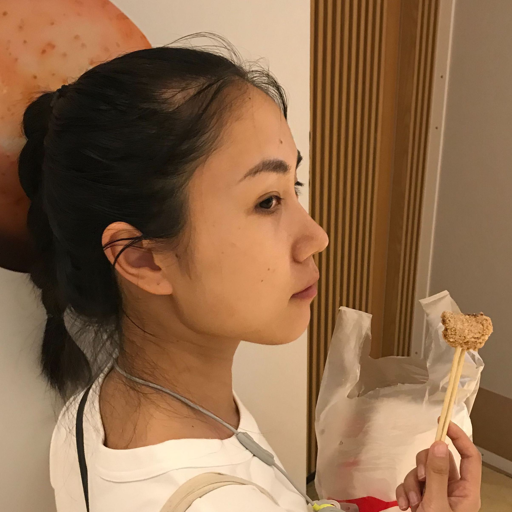

In [45]:
IMG = Image.open(IMG_URL)
IMG.resize((512,512))


In [46]:
transform_func = get_transforms(img_size=512, training=False)
img_tensor = transform_func(IMG)

In [51]:
backbone_model = load_pretrained_vanilla("VanillaNet-10", num_classes=None, load_ema=True)
backbone_model = backbone_model.eval()

backbone_model.switch_to_inference()

types of weights: dict_keys(['model', 'model_ema'])


In [52]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [53]:
backbone_model = backbone_model.to(device)

back

embeded youtube video: https://www.youtube.com/watch?v=o8pJcvL8Lw8

<iframe width="560" height="315" src="https://www.youtube.com/embed/o8pJcvL8Lw8" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [58]:
def tensor_to_img(img_tensor) ->  Image:
    """
    Convert a tensor to an image.
    """
    img_tensor = img_tensor[0].cpu()
    img_tensor = img_tensor * torch.Tensor(IMAGENET_DEFAULT_STD).view(3, 1, 1)
    img_tensor = img_tensor + torch.Tensor(IMAGENET_DEFAULT_MEAN).view(3, 1, 1)
    img_tensor = img_tensor.clamp(0, 1)
    img = T.ToPILImage()(img_tensor)
    return img

In [ ]:
def build_forward(model: VanillaNet, depth: int):
    def forward_depth(x: torch.Tensor,):
        """
        Forward the model for several steps.
        """
        x = model.stem(x)
        for i in range(depth):
            x = model.stages[i](x)
        return x
    return forward_depth


def total_variance(img_tensor):
    tv_horizontal = torch.pow(img_tensor[:,:,1:,:] - img_tensor[:,:,:-1,:], 2).sum()
    tv_vertical = torch.pow(img_tensor[:,:,:,1:] - img_tensor[:,:,:,:-1], 2).sum()
    return tv_horizontal + tv_vertical


output = Output()
display(output)


LR = 1e-1
EPOCH_STEPS = 500
SIZE = 512
FORWARD_DEPTH = 4

forward_func = build_forward(backbone_model, FORWARD_DEPTH)

reconstruct_img = nn.Parameter(torch.randn(1, 3, SIZE, SIZE, device=device), requires_grad=True)

with torch.no_grad():
    y_ = forward_func(img_tensor.unsqueeze(0).to(device))

optim = torch.optim.AdamW([reconstruct_img], lr=LR)
crit = nn.MSELoss()
t = tqdm(range(EPOCH_STEPS))

for i in t:
    loss = crit(forward_func(reconstruct_img), y_) + total_variance(reconstruct_img) * .1e-4
    loss.backward()
    optim.step()
    optim.zero_grad()
    if i % 20 == 0:
        t.set_description(f"loss: {loss.item():.4f}")
        with torch.no_grad():
            img = tensor_to_img(reconstruct_img)
            output.clear_output()
            with output:
                display(img.resize((512,512)))

## Decomposition rank

In [78]:
@interact
def before_and_after(input_dim=(2,1000), output_dim=(2,1000), rank = (2,1000)):
    print(f"Before combine, the number of parameters: ({input_dim} x {rank}) + ({rank} x {output_dim} ) = {input_dim * rank + output_dim * rank}")
    print(f"After combine, the number of parameters: ({input_dim} x {output_dim}) = {(input_dim * output_dim)}")
    print(f"After/Before: {(input_dim * output_dim) / (input_dim * rank + output_dim * rank):.2%}")

interactive(children=(IntSlider(value=501, description='input_dim', max=1000, min=2), IntSlider(value=501, des…